In [1]:
import pandas as pd

pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)

### Cargo Librerias y datasets

In [2]:
from pathlib import Path
import sys
from random import sample
from sklearn.model_selection import train_test_split
sys.path.append('../data')
sys.path.append('../')

In [3]:
from lib import transformers, data

In [4]:
import matplotlib.pyplot as plt

In [5]:
## Validamos si lo que sacamos nos impactó en el budget
def plot_budget_validation(df_filter, df_validation, log_var=True):
    (
        df_filter
            .budget
            .value_counts()
            .value_counts(normalize=True)
            .sort_index()
            .plot(logx=log_var, logy=log_var, label='movies_gross_filter')
    )
    (
        df_validation
            .budget
            .value_counts()
            .value_counts(normalize=True)
            .sort_index()
            .plot(logx=log_var, logy=log_var, label='movies_gross')
    )

    plt.legend(loc='best')
    plt.title('Budget of films per movie')

In [6]:
def load_budget_train_dev_test(df):

    X = df.loc[ : , df.columns != 'budget'] #me quedo con train solo
    y = df.budget.values  #var target y

    # Splite en 80:20, esto es train y val
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=101)

    # AHora con el 0.875, tengo mi test, y finalmente me queda 70,20,10   (ver que 0.8 * 0.875 = 0.7)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.875, random_state=101)

    print("len(X): {} len(y): {} \nlen(X_train): {}, len(X_val): {}, len(X_test): \
    {} \nlen(y_train): {}, len(y_val): {}, len(y_test): {}".format(len(X), len(y),\
    len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), \
    len(y_test))) 
    
    return X_train.to_dict(orient='records'), X_val.to_dict(orient='records'), X_test.to_dict(orient='records'), y_train, y_val, y_test

In [7]:
# si todo va bien lo sumamos a los transformers
from sklearn.base import BaseEstimator, TransformerMixin

class DirectorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, min_cnt_movies=2):
        self.min_cnt_movies = min_cnt_movies

    def fit(self, X, y):
        # Esto no es la forma mas elegante, pero es mas comodo y a esta altura priorizo la comodidad
        # Llevamos las cosas de nuevo a un DataFrame y calculamos features por director
        directors_stats = (
            pd.DataFrame(X)
                .groupby('director')
                .agg({
                'tconst': 'count'                
                }
            )
        )

        # Para hacer flattening de las columnas
        # https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
        directors_stats.columns = [
            '_'.join(i)
            for i in zip(directors_stats.columns.get_level_values(1), directors_stats.columns.get_level_values(0))
        ]

        # Guardamos las estadisticas
        self.directors_stats_ = directors_stats

        # Diccionario con los datos para los directores comunes
        self.directors_stats_lk_ = (
            directors_stats[directors_stats.count_tconst >= self.min_cnt_movies].to_dict(orient='index')
        )

        # Valor default para los que consideramos que tenemos demasiado poca data
        self.default_ = directors_stats[directors_stats.count_tconst < self.min_cnt_movies].mean(0).to_dict()
        if self.min_cnt_movies > 1:
            self.default_ = directors_stats[directors_stats.count_tconst < self.min_cnt_movies].mean(0).to_dict()
        else:
            self.default_ = directors_stats.mean(0).to_dict()
        return self

    def transform(self, X):
        res = []
        for e in X:
            if e['director'] in self.directors_stats_lk_:
                res.append(self.directors_stats_lk_[e['director']])
            else:
                res.append(self.default_)
        return res

## Cargamos movies & movies gross
#### Movies lo cargamos para tener el ds a mano por si queremos agregar algo mas.

In [8]:
# Si quiero cargar todo
# movies, movies_gross = data.load_data(Path('../data/'))

# Si quiero cargar solo budget
PATH = Path('../data/')
movies_gross = data.load_movie_gross(PATH)

In [9]:
# movies.head()

In [10]:
movies_gross.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police officer|terrorist plot,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [11]:
# creamos variable tconst para poder matchear (si queremos) con movies
movies_gross['tconst']=movies_gross.movie_imdb_link.apply(lambda x: x.replace('http://www.imdb.com/title/','').replace('/?ref_=fn_tt_tt_1',''))

In [12]:
#Renombro columna de director y year
# Esto lo hago para usar las funciones de los transformers ... Si vemos que tiene sentido y suma, hacemos nuestra propia funcion, por el momento es test
movies_gross['startYear'] = movies_gross['title_year']
movies_gross['director']  = movies_gross['director_name']

In [13]:
movies_gross.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,tconst,startYear,director
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,tt0499549,2009.0,James Cameron
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,tt0449088,2007.0,Gore Verbinski
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,tt2379713,2015.0,Sam Mendes
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police officer|terrorist plot,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,tt1345836,2012.0,Christopher Nolan
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,tt5289954,NaN,Doug Walker


In [14]:
# limpio el df movie_gross y me quedo con los datos que pueden servir
df= movies_gross[['director', 'actor_1_name','actor_2_name', 'actor_3_name', 'genres', 'duration', 'movie_title', 'movie_imdb_link', 'language', 'country','title_year', 'startYear','content_rating','tconst','budget']]
df.head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,duration,movie_title,movie_imdb_link,language,country,title_year,startYear,content_rating,tconst,budget
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,178.0,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,English,USA,2009.0,2009.0,PG-13,tt0499549,237000000.0
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,169.0,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,English,USA,2007.0,2007.0,PG-13,tt0449088,300000000.0


## Data Cleanning

In [15]:
df.genres.value_counts()

Drama                                       236
Comedy                                      209
Comedy|Drama                                191
Comedy|Drama|Romance                        187
Comedy|Romance                              158
                                           ... 
Crime|Documentary|News                        1
Action|Comedy|Drama                           1
Biography|Crime|Drama|Mystery|Thriller        1
Comedy|Drama|Fantasy|Horror                   1
Adventure|Drama|Fantasy|Mystery|Thriller      1
Name: genres, Length: 914, dtype: int64

In [16]:
# me quedo con las peliculas que tengan un budget asignado, y también con las que sean de 1970 (revisar el año) y con las que no esten duplicadas
# revisar el tipo de moneda de cada pais, porque me suena a que o son outliers o estan en otra moneda

from dateutil.parser import parse

df = df[~df.budget.isna()].copy()
df = df[df.title_year > 1970].copy()
df['tconst'] = df.movie_imdb_link.apply(lambda x: x.split('/')[4])
df = df.drop_duplicates(df.columns[df.columns.isin(['tconst'])],
                        keep='first')

In [17]:
df.sort_values('budget', ascending=False).head()

,director,actor_1_name,actor_2_name,actor_3_name,genres,duration,movie_title,movie_imdb_link,language,country,title_year,startYear,content_rating,tconst,budget
2988,Joon-ho Bong,Doona Bae,Kang-ho Song,Ah-sung Ko,Comedy|Drama|Horror|Sci-Fi,110.0,The Host,http://www.imdb.com/title/tt0468492/?ref_=fn_tt_tt_1,Korean,South Korea,2006.0,2006.0,R,tt0468492,1.221550e+10
3859,Chan-wook Park,Min-sik Choi,Yeong-ae Lee,Hye-jeong Kang,Crime|Drama,112.0,Lady Vengeance,http://www.imdb.com/title/tt0451094/?ref_=fn_tt_tt_1,Korean,South Korea,2005.0,2005.0,R,tt0451094,4.200000e+09
3005,Lajos Koltai,Marcell Nagy,Péter Fancsikai,Bálint Péntek,Drama|Romance|War,134.0,Fateless,http://www.imdb.com/title/tt0367082/?ref_=fn_tt_tt_1,Hungarian,Hungary,2005.0,2005.0,R,tt0367082,2.500000e+09
2323,Hayao Miyazaki,Minnie Driver,Jada Pinkett Smith,Billy Crudup,Adventure|Animation|Fantasy,134.0,Princess Mononoke,http://www.imdb.com/title/tt0119698/?ref_=fn_tt_tt_1,Japanese,Japan,1997.0,1997.0,PG-13,tt0119698,2.400000e+09
2334,Katsuhiro Ôtomo,William Hootkins,Robin Atkin Downes,Rosalind Ayres,Action|Adventure|Animation|Family|Sci-Fi|Thriller,103.0,Steamboy,http://www.imdb.com/title/tt0348121/?ref_=fn_tt_tt_1,Japanese,Japan,2004.0,2004.0,PG-13,tt0348121,2.127520e+09


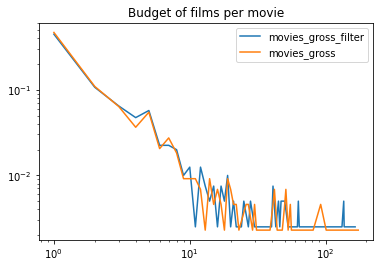

In [18]:
log_vars = True
plot_budget_validation(df, movies_gross, log_vars)

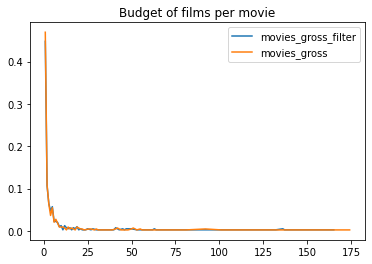

In [19]:
plot_budget_validation(df, movies_gross, False)

In [20]:
# cuanto representan las peliculas de USA 
(df.country == 'USA').sum() / len(df)

0.7695540508989026

In [21]:
df_usa_budget = df[df.country == 'USA'].copy()

### Analizo si me mueve la aguja tener solo US

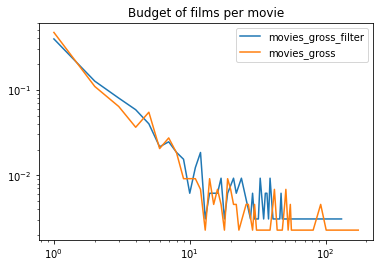

In [22]:
plot_budget_validation(df_usa_budget, movies_gross)

### Comparo el filtrado vs el real

In [23]:
df_usa_budget[['title_year','budget']].describe()

,title_year,budget
count,3296.000000,3.296000e+03
mean,2003.541869,3.636732e+07
std,9.081192,4.236952e+07
min,1971.000000,2.180000e+02
25%,1999.000000,7.500000e+06
50%,2005.000000,2.200000e+07
75%,2011.000000,5.000000e+07
max,2016.000000,3.000000e+08


In [24]:
movies_gross[['title_year','budget']].describe()

,title_year,budget
count,4935.000000,4.551000e+03
mean,2002.470517,3.975262e+07
std,12.474599,2.061149e+08
min,1916.000000,2.180000e+02
25%,1999.000000,6.000000e+06
50%,2005.000000,2.000000e+07
75%,2011.000000,4.500000e+07
max,2016.000000,1.221550e+10


In [25]:
df_usa_budget.actor_2_name.value_counts()

Morgan Freeman        15
Charlize Theron       11
Brad Pitt             11
Meryl Streep           9
James Franco           9
                      ..
Sandra Staggs          1
Michael Jai White      1
Giancarlo Giannini     1
Katie Aselton          1
Patsy Kensit           1
Name: actor_2_name, Length: 2006, dtype: int64

### Divido el dataset en train, val y test
### y obtengo los siguientes data sets:

X_train, X_val, X_test , lo mismo con la var y

In [26]:
 X_train, X_val, X_test, y_train, y_val, y_test = load_budget_train_dev_test(df)

len(X): 4283 len(y): 4283 
len(X_train): 2997, len(X_val): 857, len(X_test):     429 
len(y_train): 2997, len(y_val): 857, len(y_test): 429


In [27]:
# Acá vemos la data de train
X_train[0]

{'director': 'Jafar Panahi',
 'actor_1_name': 'Fereshteh Sadre Orafaiy',
 'actor_2_name': 'Nargess Mamizadeh',
 'actor_3_name': 'Mojgan Faramarzi',
 'genres': 'Drama',
 'duration': 90.0,
 'movie_title': 'The Circle\xa0',
 'movie_imdb_link': 'http://www.imdb.com/title/tt0255094/?ref_=fn_tt_tt_1',
 'language': 'Persian',
 'country': 'Iran',
 'title_year': 2000.0,
 'startYear': 2000.0,
 'content_rating': 'Not Rated',
 'tconst': 'tt0255094'}

In [28]:
# miro el budget para el 1er row en train
y_train[0]

10000.0

In [29]:
X_val[0]
# data.keys()

{'director': 'Jessy Terrero',
 'actor_1_name': "Mo'Nique",
 'actor_2_name': 'Snoop Dogg',
 'actor_3_name': 'Tom Arnold',
 'genres': 'Comedy',
 'duration': 92.0,
 'movie_title': 'Soul Plane\xa0',
 'movie_imdb_link': 'http://www.imdb.com/title/tt0367085/?ref_=fn_tt_tt_1',
 'language': 'English',
 'country': 'USA',
 'title_year': 2004.0,
 'startYear': 2004.0,
 'content_rating': 'R',
 'tconst': 'tt0367085'}

In [30]:
y_val[0]

16000000.0

## Modelo básico

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_union, make_pipeline
from sklearn.feature_extraction import DictVectorizer

import autosklearn.classification
from autosklearn.metrics import roc_auc

def get_features_pipe(
        use_years: bool, use_genre: bool, 
        use_director: bool, director_kws: dict=None, post_processing=None):
    """
    Construye el pipeline de features de forma parametrizada
    """
    # director_kws solo tiene sentido cuando use_director=True. 
    # Esto nos va a traer dolores de cabeza a la hora de explorar el espacio de hyper parametros
    # TODO: esto debería permitir cachear los datasets transformados
    
    steps = []
    if use_years:
        steps.append(make_pipeline(transformers.YearsAgo(), DictVectorizer(sparse=False)))
    
    if use_genre:
        steps.append(make_pipeline(transformers.GenreDummies(), DictVectorizer(sparse=False)))
        
    if use_director:
        director_kws = director_kws or {}
        # cuando hacemos **director_kws usamos ese diccionario para pasar parametros
        steps.append(make_pipeline(DirectorFeatures(**director_kws), DictVectorizer(sparse=False)))
    
    res = make_union(*steps)
    if post_processing:
        res = make_pipeline(res, post_processing)
    return res

def get_model_pipe(features_pipe, estimator):
    return make_pipeline(features_pipe, estimator)

/home/constantine/Documents/cursos/2020-machinelearning/ml_env/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [32]:
# Creamos modelo
model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=LogisticRegression()   
)

model

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('featureunion',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('pipeline-1',
                                                                  Pipeline(memory=None,
                                                                           steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                                  separator='=',
                                                                                          

In [33]:
len(model)

2

In [35]:
# acá tengo un bug, en la entrada de las variables
# model.fit(X_train, y_train)

### Visualizamos los modelos

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

In [ ]:
dt = X_test
y_dt = y_test

for _ in range(10):
    i = randint(0, len(dt))

    plt.figure()
    plt.title('{originalTitle} ({startYear:.00f}, {genres})'.format(**dt[i]))
    preds = np.asarray([m.predict_proba([dt[i]])[0,1] for m in models])
    preds = preds[1:] - preds[:-1]

    plt.plot(mids, preds, '-o', label='predicted distribution')
    plt.plot([y_dt.iloc[i], y_dt.iloc[i]], [0, preds.max()], label='true rating')
    plt.plot([(preds * mids).sum(), (preds * mids).sum()], [0, preds.max()], label='average prediction')
    plt.plot([mids[preds.argmax()], mids[preds.argmax()]], [0, preds.max()], label='prediction mode')
    plt.legend(loc='best')
    plt.xlabel('Rating value')
    plt.ylabel('Probabilty')